# Examples and Applications

During this lesson, we'll explore some variational algorithm examples and how to apply them:

- How to write a custom variational algorithm
- How to apply a variational algorithm to find minimum eigenvalues
- How to utilize variational algorithms to solve application use cases

Note that the Qiskit patterns framework can be applied to all the problems we introduce here. However, to avoid repetition, we will only explicitly call out the framework steps in one example case, run on real hardware.

## Table of Contents

1. [Problem Definitions](#problem-definitions)  
2. [Custom VQE](#custom-vqe)  
   - [Experimenting to Improve Speed and Accuracy](#experimenting-to-improve-speed-and-accuracy)  
   - [Add Reference State](#add-reference-state)  
   - [Change Initial Point](#change-initial-point)  
   - [Experimenting with Different Optimizers](#experimenting-with-different-optimizers)  
3. [VQD Example](#vqd-example)  
   - [Step 1: Map Classical Inputs to a Quantum Problem](#step-1-map-classical-inputs-to-a-quantum-problem)  
   - [Change Betas](#change-betas)  
   - [Step 2: Optimize Problem for Quantum Execution](#step-2-optimize-problem-for-quantum-execution)  
   - [Step 3: Execute Using Qiskit Primitives](#step-3-execute-using-qiskit-primitives)  
   - [Step 4: Post-process, Return Result in Classical Format](#step-4-post-process-return-result-in-classical-format)  
4. [Quantum Chemistry: Ground State and Excited Energy Solver](#quantum-chemistry-ground-state-and-excited-energy-solver)  
   - [Excited States](#excited-states)  
   - [Real Hardware and a Final Cautionary Message](#real-hardware-and-a-final-cautionary-message)  
5. [Optimization: Max-Cut](#optimization-max-cut)  
6. [Summary](#summary)


## Problem Definitions

### Problem definitions

Imagine that we want to use a variational algorithm to find the eigenvalue of the following observable:

$$
\hat{O}_1 = 2II - 2XX + 3YY - 3ZZ,
$$

This observable has the following eigenvalues:

$$
\left\{
\begin{aligned}
\lambda_0 &= -6 \\
\lambda_1 &= 4 \\
\lambda_2 &= 4 \\
\lambda_3 &= 6
\end{aligned}
\right.
$$

And eigenstates:

$$
\left\{
\begin{aligned}
|\phi_0\rangle &= \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) \\
|\phi_1\rangle &= \frac{1}{\sqrt{2}}(|00\rangle - |11\rangle) \\
|\phi_2\rangle &= \frac{1}{\sqrt{2}}(|01\rangle - |10\rangle) \\
|\phi_3\rangle &= \frac{1}{\sqrt{2}}(|01\rangle + |10\rangle)
\end{aligned}
\right.
$$


In [1]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

## Custom VQE

We'll first explore how to construct a VQE instance manually to find the lowest eigenvalue for $\hat{O}_1$. This will incorporate a variety of techniques that we have covered throughout this course.


In [2]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

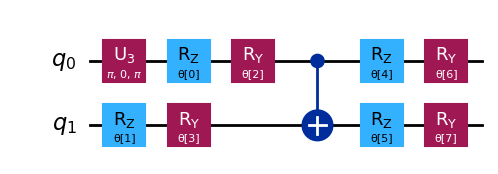

In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit

import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')

In [5]:
# We will start debugging on local simulators.
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

In [4]:
# We now set an initial set of parameters:
import numpy as np

x0 = np.ones(raw_ansatz.num_parameters)
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
# We can minimize this cost function to calculate optimal parameters
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time


   Normal return from subroutine COBYLA

   NFVALS =  136   F =-6.000000E+00    MAXCV = 0.000000E+00
   X = 1.779032E+00   9.443488E-01   1.570750E+00   2.105188E-05   1.937654E+00
       1.203965E+00   6.058825E-01   6.058508E-01


In [7]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999988971089
       x: [ 1.779e+00  9.443e-01  1.571e+00  2.105e-05  1.938e+00
            1.204e+00  6.059e-01  6.059e-01]
    nfev: 136
   maxcv: 0.0

In [8]:
# Because this toy problem uses only two qubits, we can check this by using NumPy's linear algebra eigensolver.
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 136
Time (s): 0.06483793258666992
Percent error: 1.84e-09


As you can see, the result is extremely close to the ideal.

### Experimenting to Improve Speed and Accuracy


### Add Reference State

In the previous example we have not used any reference operator $U_R$. Now let us think about how the ideal eigenstate  
$\frac{1}{\sqrt{2}}(\lvert 00\rangle + \lvert 11\rangle)$ can be obtained. Consider the following circuit.



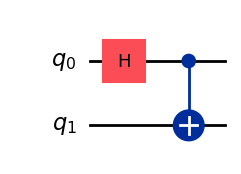

In [9]:
from qiskit import QuantumCircuit

ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0, 1)

ideal_qc.draw("mpl")

In [10]:
# We can quickly check that this circuit gives us the desired state.
from qiskit.quantum_info import Statevector

Statevector(ideal_qc)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


Now that we have seen how a circuit preparing the solution state looks like, it seems reasonable to use a Hadamard gate as a reference circuit, so that the full ansatz becomes:

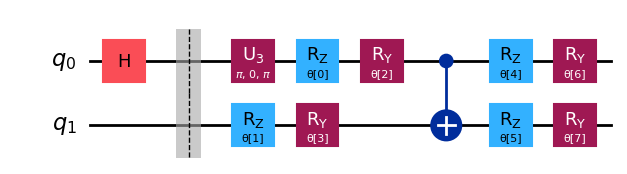

In [11]:
reference = QuantumCircuit(2)
reference.h(0)
# Include barrier to separate reference from variational form
reference.barrier()

ref_ansatz = raw_ansatz.decompose().compose(reference, front=True)

ref_ansatz.draw("mpl")

For this new circuit, the ideal solution could be reached with all the parameters set to 0, so this confirms that the choice of reference circuit is reasonable.

Now let us compare the number of cost function evaluations, optimizer iterations and time taken with those of the previous attempt.

In [12]:
import time

start_time = time.time()

ref_result = minimize(cost_func_vqe, x0, args=(ref_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [13]:
# Using our optimial parameters to calculate the minimum eigenvalue:
experimental_min_eigenvalue_ref = cost_func_vqe(result.x, raw_ansatz, observable_1, estimator)
print(experimental_min_eigenvalue_ref)

-5.999999988971089


In [14]:
print("ADDED REFERENCE STATE:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
print(
    f"Percent error: {abs((experimental_min_eigenvalue_ref - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

ADDED REFERENCE STATE:
Number of iterations: 136
Time (s): 0.11112713813781738
Percent error: 1.84e-09


### Change initial point

Now that we have seen the effect of adding the reference state, we will go into what happens when we choose different initial points $\vec{\theta}_0$. In particular we will use $\vec{\theta}_0 = (0, 0, 0, 0, 6, 0, 0, 0)$ and $\vec{\theta}_0 = (6, 6, 6, 6, 6, 6, 6, 6)$.

Remember that, as discussed when the reference state was introduced, the ideal solution would be found when all the parameters are 0, so the first initial point should give fewer evaluations.


In [15]:
import time

start_time = time.time()

x0 = [0, 0, 0, 0, 6, 0, 0, 0]

x0_1_result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [16]:
print("INITIAL POINT 1:")
print(f"""Number of iterations: {x0_1_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 1:
Number of iterations: 124
Time (s): 0.08193087577819824


Adjusting inital point to $\vec{\theta}_0 = (6,6,6,6,6,6,6,6,6)$

In [17]:
import time

start_time = time.time()

x0 = 6 * np.ones(raw_ansatz.num_parameters)

x0_2_result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

In [18]:
print("INITIAL POINT 2:")
print(f"""Number of iterations: {x0_2_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 2:
Number of iterations: 121
Time (s): 0.08273983001708984


By experimenting with different initial points, you might be able to achieve convergence faster and with fewer function evaluations.

### Experimenting with Different Optimizers

We can adjust the optimizer using SciPy minimize 's method argument, with more options found here. We originally used a constrained minimizer ( COBYLA ). In this example, we'll explore using an unconstrained minimizer ( BFGS ) instead


## VQD Example
Here we implement the Qiskit patterns framework, explicitly.




### Step 1: Map classical inputs to a quantum problem

Now instead of looking for only the lowest eigenvalue of our observables, we will look for all 4, (where $k = 4$).

Remember that the cost functions of VQD are:

$$
C_\ell(\vec{\theta}) := \langle \psi(\vec{\theta})| \hat{H} | \psi(\vec{\theta}) \rangle + \sum_{j=0}^{\ell-1} \beta_j |\langle \psi(\vec{\theta}) | \psi(\vec{\theta}^{(j)}) \rangle|^2 \quad \forall \, \ell \in \{1, \cdots, k\} = \{1, \cdots, 4\}
$$

This is particularly important because a vector $\vec{\beta} = (\beta_0, \cdots, \beta_{k-1})$ (in this case $(\beta_0, \beta_1, \beta_2, \beta_3)$) must be passed as an argument when we define the `VQD` object.

Also, in Qiskit’s implementation of VQD, instead of considering the effective observables described in the previous notebook, the fidelities $|\langle \psi(\vec{\theta})|\psi(\vec{\theta}^{(j)}) \rangle|^2$ are calculated directly via the `ComputeUncompute` algorithm, that leverages a `Sampler` primitive to sample the probability of obtaining $|0\rangle$ for the circuit $U_A^\dagger(\vec{\theta}^{(j)}) U_A(\vec{\theta})$. This works precisely because this probability is:

$$
p_0 = | \langle 0 | U_A^\dagger(\vec{\theta}^{(j)}) U_A(\vec{\theta}) | 0 \rangle |^2 
= | \langle 0 | U_A^\dagger(\vec{\theta}^{(j)}) (U_A(\vec{\theta}) | 0 \rangle) |^2 
= | \langle \psi(\vec{\theta}^{(j)}) | \psi(\vec{\theta}) \rangle |^2
$$


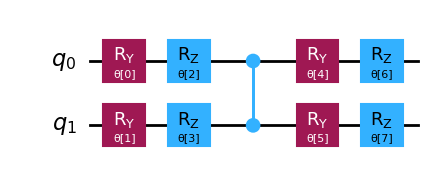

In [19]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw('mpl')

Let's start by examining the following observable:

$$
\hat{O}_2 := 2II - 3XX + 2YY - 4ZZ
$$

This observable has the following eigenvalues:

$$
\left\{
\begin{aligned}
\lambda_0 &= -7 \\
\lambda_1 &= 3 \\
\lambda_2 &= 5 \\
\lambda_3 &= 7
\end{aligned}
\right\}
$$

And eigenstates:

$$
\left\{
\begin{aligned}
|\phi_0\rangle &= \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle) \\
|\phi_1\rangle &= \frac{1}{\sqrt{2}}(|00\rangle - |11\rangle) \\
|\phi_2\rangle &= \frac{1}{\sqrt{2}}(|01\rangle + |10\rangle) \\
|\phi_3\rangle &= \frac{1}{\sqrt{2}}(|01\rangle - |10\rangle)
\end{aligned}
\right\}
$$


In [20]:
from qiskit.quantum_info import SparsePauliOp

observable_2 = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])

We'll be using the following function to calculate the overlap penalty. Note that this is still part of mapping the problem to quantum circuits. However, as discussed in the previous lesson, this function calculates the overlap between a current variational circuit and the optimized circuit from a previous, lower-energy/cost state obtained. The new circuit being generated also has to be transpiled to run on real hardware. We have seen this function before, used on a simulator. Here, we must already consider the transpiling and related optimization for when we use a real backend, hence the lines around "if realbackend == 1". This is mixing a bit of step 2, but we will call out step 2 explicitly, later.

In [21]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler, realbackend,backend):

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        if realbackend == 1:
            pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
            fidelity_circuit = pm.run(fidelity_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

Now we add VQD's cost function. Note that compared to the previous lesson, we now have two additional arguments ("realbackend" and "backend") to help us with transpilation when we use real backends.

In [22]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian, realbackend, backend):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler, realbackend, backend)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

In [23]:
# Once again, we will use simulators for debugging, and then move on to real hardware.
from qiskit.primitives import StatevectorSampler
from qiskit.primitives import StatevectorEstimator

sampler = StatevectorSampler(default_shots=4092)
estimator = StatevectorEstimator()


In [27]:
# Here we introduce the number of states we wish to calculate, the penalties, and a set of initial parameters, x0.
from qiskit.quantum_info import SparsePauliOp
import numpy as np

k = 4
betas = [50, 60, 40]
x0 = np.ones(8)

In [25]:
# We will now test the algorithm using simulators:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2, realbackend, None), method="COBYLA", options={'maxiter': 200, 'tol':0.000001})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.999999999993331
       x: [ 1.571e+00  1.571e+00  1.993e+00  2.164e+00  1.020e+00
            1.215e+00  1.693e+00  2.789e+00]
    nfev: 192
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 3.6999637825214435
       x: [ 9.742e-01  1.023e+00  1.111e+00  1.304e+00  1.170e+00
            1.246e+00  8.846e-01  1.068e+00]
    nfev: 107
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.561360736434458
       x: [ 2.887e+00  2.702e+00  2.148e+00  7.797e-01  7.190e-01
            2.129e+00  1.867e+00  4.877e-01]
    nfev: 109
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 6.6166040196971485
       x: [ 2.954e+00  2.886e+00  5.394e-01  2.063e+00  2.359e+00
            6.369e-01  4.616e-01  2.316e+00]
    nfev: 125
   maxcv: 0.0


In [26]:
eigenvalues

[np.float64(-6.999999999993331),
 np.float64(3.6999637825214435),
 np.float64(5.561360736434458),
 np.float64(6.6166040196971485)]

These results are fairly close to the expected ones except for approximation error and global phase. We could adjust the tolerance on the classical optimizer and/or the penalties for statevector overlap to obtain more precise values.

In [28]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]
    
    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
    )

Percent error: 9.53e-13
Percent error: 2.33e-01
Percent error: 1.12e-01
Percent error: 5.48e-02


### Change Betas

As mentioned in the previous lesson, the values of $\vec{\beta}$ should be bigger than the difference between eigenvalues. Let us see what happens when they do not satisfy that condition with $\hat{O}_2$

$$
\hat{O}_2 = 2II - 3XX + 2YY - 4ZZ
$$

with eigenvalues

$$
\left\{
\begin{aligned}
\lambda_0 &= -7 \\
\lambda_1 &= 3 \\
\lambda_2 &= 5 \\
\lambda_3 &= 7
\end{aligned}
\right\}
$$



In [29]:
from qiskit.quantum_info import SparsePauliOp

k = 4
betas = np.ones(3)
x0 = np.zeros(8)

In [30]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2, realbackend, None), method="COBYLA", options = {'tol' : 0.01, 'maxiter': 200})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.999586475781003
       x: [-1.562e+00  1.575e+00 -8.948e-03 -9.178e-03  7.737e-01
           -7.961e-01  4.627e-02 -3.993e-02]
    nfev: 175
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.4789378876717092
       x: [ 1.257e-03  2.362e-03  9.919e-01  2.244e-03  3.776e-03
           -1.991e-03  5.355e-04 -1.916e-03]
    nfev: 38
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4967932875891852
       x: [-1.038e-02 -9.146e-03  9.275e-04  1.000e+00 -1.580e-02
           -1.446e-02 -1.204e-01  1.246e-01]
    nfev: 44
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.5110807561380275
       x: [ 5.235e-03 -1.973e-03  9.982e-01  9.986e-01 -3.779e-03
           -1.722e-03 -5.979e-03  9.967e-01]
    nfev: 41
   maxcv: 0.0


In [31]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]
    
    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
    )

Percent error: 5.91e-05
Percent error: 1.49e+00
Percent error: 1.10e+00
Percent error: 9.27e-01


This time, the optimizer returns the same state $\lvert \phi_0 \rangle = \frac{1}{\sqrt{2}}(\lvert 00 \rangle + \lvert 11 \rangle)$ as a proposed solution to all eigenstates: which is clearly wrong. This happens because the betas were too small to penalize the minimum eigenstate in the successive cost functions. Therefore, it was not excluded from the effective search space in later iterations of the algorithm, and always chosen as the best possible solution.

We recommend experimenting with the values of $\vec{\beta}$, and ensuring they are bigger than the difference between eigenvalues.


### Step 2: Optimize Problem for Quantum Execution

To run this on real hardware, we must optimize the quantum circuits for our quantum computer of choice. For our purposes here, we will simply use the least-busy backend.


In [32]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)
# Or use a specific backend
#backend = service.backend("ibm_cusco")
print(backend)

AccountNotFoundError: 'Unable to find account.'

We will transpile our circuit using a preset pass manager and optimization level 3.

In [33]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable_2.apply_layout(layout = isa_ansatz.layout)

NameError: name 'backend' is not defined

### Step 3: Execute Using Qiskit Primitives

Taking care to reset our betas to sufficiently high values, we can now run our calculation on real quantum hardware.


In [ ]:
#Estimated compute resource usage: 25 minutes. Benchmarked at 24 min, 30 s on ibm_nazca on 5-30-24

k = 2
betas = [30, 50, 80]
x0 = np.zeros(8)

real_prev_states = []
real_prev_opt_parameters = []
real_eigenvalues = []

realbackend = 1

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)
    sampler = Sampler(mode = session)
    
    for step in range(1, k + 1):
    
        if step > 1:
            real_prev_states.append(isa_ansatz.assign_parameters(prev_opt_parameters))
    
        result = minimize(cost_func_vqd, x0, args=(isa_ansatz, real_prev_states, step, betas, estimator, sampler, isa_observable, realbackend, backend), method="COBYLA", options = {'maxiter':200})
        print(result)

        real_prev_opt_parameters = result.x
        real_eigenvalues.append(result.fun)

session.close()
print(real_eigenvalues)

### Step 4: Post-process, Return Result in Classical Format

Our output is structurally similar to what has been dicussed in previous lessons and examples. But there is something problematic in the results above, from which we can derive a cautionary message for the context of excited states. To limit computing time used on this learning example, we set a maximum number of iterations for classical optimizer that was potentially too low: 200 iterations. A previous calculation above, on a simulator, failed to converge in 200 iterations. Here, ours did converge... but to what tolerance? We have not specified a tolerance for COBYLA to consider itself "converged". A glance at the function value and comparison with previous runs tells us that COBYLA was not close to converging to the precision we require.

There is another issue: the energy of the first excited state appears to be lower than the energy of the ground state! See if you can explain how this could happen. Hint: it is related to the convergence point we just addressed. This behavior is explained in detail below after VQD is applied to the H2 molecule.


## Quantum Chemistry: Ground State and Excited Energy Solver

Our objective is to minimize the expectation value of the observable representing energy (Hamiltonian $\hat{\mathcal{H}}$):

$$
\min_{\vec{\theta}} \langle \psi(\vec{\theta}) | \hat{\mathcal{H}} | \psi(\vec{\theta}) \rangle
$$


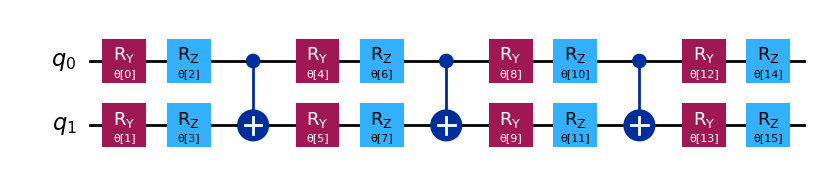

In [34]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

chem_ansatz = EfficientSU2(H2_op.num_qubits)

chem_ansatz.decompose().draw("mpl")

In [35]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit


def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [ ]:
# We now set an initial set of parameters:
import numpy as np

x0 = np.ones(chem_ansatz.num_parameters)

In [36]:
# We can minimize this cost function to calculate optimal parameters, and we can check our code first by using a local simulator.
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

In [37]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(chem_ansatz, H2_op, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

result

ValueError: Length of ('θ[0]', 'θ[1]', 'θ[2]', 'θ[3]', 'θ[4]', 'θ[5]', 'θ[6]', 'θ[7]', 'θ[8]', 'θ[9]', 'θ[10]', 'θ[11]', 'θ[12]', 'θ[13]', 'θ[14]', 'θ[15]') inconsistent with last dimension of [0. 0. 0. 0. 0. 0. 0. 0.]

The minimum value of the cost function (-1.857...) is the ground state energy of the H2 molecule, in units of hartrees.

### Excited States

We can also leverage VQD to solve for $k=2$ total states (the ground state and the first excited state).


In [39]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

k = 2
betas = [33, 33]
#x0 = np.zeros(ansatz.num_parameters)
x0=[ 1.164e+00, -2.438e-01,  9.358e-04,  6.745e-02,  1.990e+00,   9.810e-02,  6.154e-01,  5.454e-01]

In [40]:
# We'll add our overlap calculation:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, H2_op, realbackend, None), method="COBYLA", options = {'tol': 0.001, 'maxiter': 2000})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.857266808049185
       x: [ 1.164e+00 -2.434e-01  8.477e-04  6.731e-02  1.989e+00
            9.870e-02  6.153e-01  5.453e-01]
    nfev: 50
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0626367383783342
       x: [ 2.558e+00  1.287e+00  1.082e+00 -4.870e-01  3.417e+00
            1.351e+00  6.752e-01  2.583e-01]
    nfev: 129
   maxcv: 0.0


In [41]:
eigenvalues

[np.float64(-1.857266808049185), np.float64(-1.0626367383783342)]

### Real Hardware and a Final Cautionary Message

To run this on real hardware, we must optimize the quantum circuits for our quantum computer of choice. For our purposes here, we will simply use the least-busy backend.


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)

In [ ]:
# We will use a preset pass manager for transpilation, and we will maximally optimize our circuit using optimization level 3.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = H2_op.apply_layout(layout = isa_ansatz.layout)

Because VQD is highly iterative, we will carry out all steps inside a Runtime session, such that our jobs will only be queued at the beginning, and not between every parameter update. Nothing else changes about the syntax for the cost function or estimator.

In [42]:
x0=[ 1.306e+00, -2.284e-01,  6.913e-02, -2.530e-02,  1.849e+00,
            7.433e-02,  6.366e-01,  5.600e-01]

In [43]:
#Estimated hardware usage: 20 min benchmarked on ibm_nazca on 5-30-24

real_prev_states = []
real_prev_opt_parameters = []
real_eigenvalues = []

realbackend = 1

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 4096
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    sampler = Sampler(mode = session)
    
    for step in range(1, k + 1):
    
        if step > 1:
            real_prev_states.append(isa_ansatz.assign_parameters(real_prev_opt_parameters))
    
        result = minimize(cost_func_vqd, x0, args=(isa_ansatz, real_prev_states, step, betas, estimator, sampler, isa_observable, realbackend, backend), method="COBYLA", options = {'tol': 0.001, 'maxiter':300})
        print(result)

        real_prev_opt_parameters = result.x
        real_eigenvalues.append(result.fun)

session.close()
print(real_eigenvalues)

NameError: name 'backend' is not defined

The ground state energy obtained (-1.83 hartrees) is not too far from the correct value (-1.85 hartrees). However, the excited state energy is quite a bit off. This is similar to the erroneous behavior we saw earlier in this lesson. The energy reported for the excited state is nearly the same as that for the ground state. In the previous case, we even saw an excited state energy that was lower than the reported ground state energy.

It is not possible for a variational calculation to yield an energy that is lower than the true ground state energy. In the earlier instance, the ground state energy we obtained was not very close to the true ground state. Since we did not obtain the true ground state energy in that case, there is no contradiction. In the present case, the ground state energy was fairly close to the correct value, and yet the excited state energy seems strangely close to that same value.

To understand better how this happened, recall that the way we find an excited state is by requiring that the variational state be orthogonal to the ground state (using the overlap circuits and penalty terms). If we fail to obtain an accurate ground state energy (or are off by a few percent), then we also fail to obtain an accurate ground state vector! So when we require that the excited state be orthogonal to the first state we found, we were not imposing orthogonality with the true ground state, but rather with some approximation of it (sometimes a poor approximation of it). Thus, the excited state was not forced to be orthogonal to the true ground state, and our energy estimates for the excited states were actually quite close to the ground state energy.

This will always be a concern in VQD. But in principle, this can be corrected by increasing the maximum number of iterations for the classical optimizer, imposing lower tolerance for the classical optimizer, and possibly also trying a different ansatz if we are habitually missing the true ground state. As we have seen, one may also need to modify the overlap penalties (betas). But that is really a separate issue. No penalty for overlap will keep you away from the true ground state, if you haven't found a very good estimate of the true ground state for the overlap circuit.

## Optimization: Max-Cut

The maximum cut (Max-Cut) problem is a combinatorial optimization problem that involves dividing the vertices of a graph into two disjoint sets such that the number of edges between the two sets is maximized. More formally, given an undirected graph 
$G = (V, E)$, where $V$ is the set of vertices and $E$ is the set of edges, the Max-Cut problem asks to partition the vertices into two disjoint subsets, $S$ and $T$, such that the number of edges with one endpoint in $S$ and the other in $T$ is maximized.

We can apply Max-Cut to solve a various problems including: clustering, network design, phase transitions, etc. We’ll start by creating a problem graph:



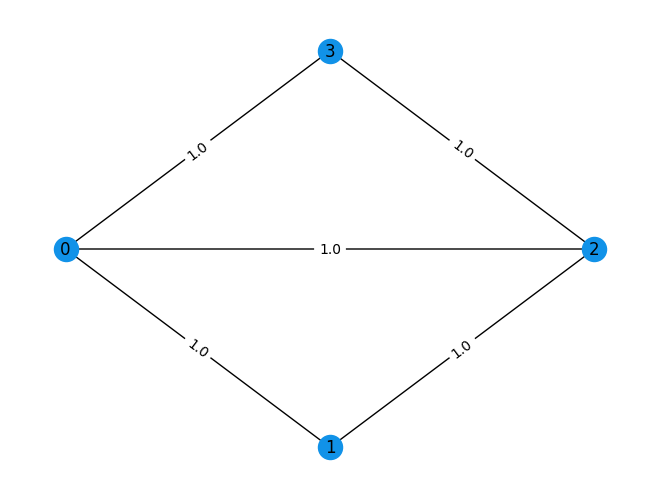

In [44]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

This problem can be expressed as a binary optimization problem. For each node $0 \leq i < n$, where $n$ is the number of nodes of the graph (in this case $n=4$), we will consider the binary variable $x_i$. This variable will have the value 1 if node $i$ is in one of the groups that we’ll label 1 and 0 if it’s in the other group, that we’ll label as 0. We will also denote as $w_{ij}$ (element $(i, j)$ of the adjacency matrix $w$) the weight of the edge that goes from node $i$ to node $j$. Because the graph is undirected, $w_{ij} = w_{ji}$. Then we can formulate our problem as maximizing the following cost function:

$$
\begin{aligned}
C(\vec{x}) &= \sum_{i,j=0}^{n} w_{ij} x_i(1 - x_j) \\
&= \sum_{i,j=0}^{n} w_{ij} x_i - \sum_{i,j=0}^{n} w_{ij} x_i x_j \\
&= \sum_{i=0}^{n} w_{ij} x_i - \sum_{i=0}^{n} \sum_{j=0}^{i} 2w_{ij} x_i x_j
\end{aligned}
$$

To solve this problem with a quantum computer, we are going to express the cost function as the expected value of an observable. However, the observables that Qiskit admits natively consist of Pauli operators, that have eigenvalues 1 and -1 instead of 0 and 1. That’s why we are going to make the following change of variable:

Where $\vec{x} = (x_0, x_1, \cdots, x_{n-1})$. We can use the adjacency matrix $w$ to comfortably access the weights of all the edges. This will be used to obtain our cost function:

$$
z_i = 1 - 2x_i \Rightarrow x_i = \frac{1 - z_i}{2}
$$

This implies that:

$$
\begin{aligned}
x_i = 0 &\Rightarrow z_i = 1 \\
x_i = 1 &\Rightarrow z_i = -1
\end{aligned}
$$

So the new cost function we want to maximize is:

$$
\begin{aligned}
C(\vec{z}) &= \sum_{i,j=0}^{n} w_{ij} \left(\frac{1 - z_i}{2}\right)\left(\frac{1 - z_j}{2}\right) \\
&= \sum_{i,j=0}^{n} \frac{w_{ij}}{4} - \sum_{i,j=0}^{n} \frac{w_{ij}}{4} z_i z_j \\
&= \sum_{i=0}^{n} \sum_{j=0}^{n} \frac{w_{ij}}{2} - \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2} z_i z_j
\end{aligned}
$$

Moreover, the natural tendency of a quantum computer is to find minima (usually the lowest energy) instead of maxima, so instead of maximizing $C(\vec{z})$ we are going to minimize:

$$
-C(\vec{z}) = \sum_{i=0}^{n} \sum_{j=0}^{n} \frac{w_{ij}}{2} z_i z_j - \sum_{i=0}^{n} \sum_{j=0}^{n} \frac{w_{ij}}{2}
$$

Now that we have a cost function to minimize whose variables can have the values $-1$ and $1$, we can make the following analogy with the Pauli $Z$:

$$
z_i = Z_i = \underbrace{I \otimes \cdots \otimes Z}_{i} \otimes \cdots \otimes I
$$

In other words, the variable $z_i$ will be equivalent to a $Z$ gate acting on qubit $i$. Moreover:

$$
Z_i |x_{n-1} \cdots x_0\rangle = z_i |x_{n-1} \cdots x_0\rangle \Rightarrow \langle x_{n-1} \cdots x_0| Z_i |x_{n-1} \cdots x_0\rangle = z_i
$$

Then the observable we are going to consider is:

$$
\hat{H} = \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2} Z_i Z_j
$$

to which we will have to add the independent term afterwards:

$$
\texttt{offset} = - \sum_{i=0}^{n} \sum_{j=0}^{i} \frac{w_{ij}}{2}
$$

The operator is a linear combination of terms with $Z$ operators on nodes connected by an edge (recall that the 0th qubit is farthest right):  
$IIZZ + IZIZ + IZZI + ZIIZ + ZZII$.

Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.


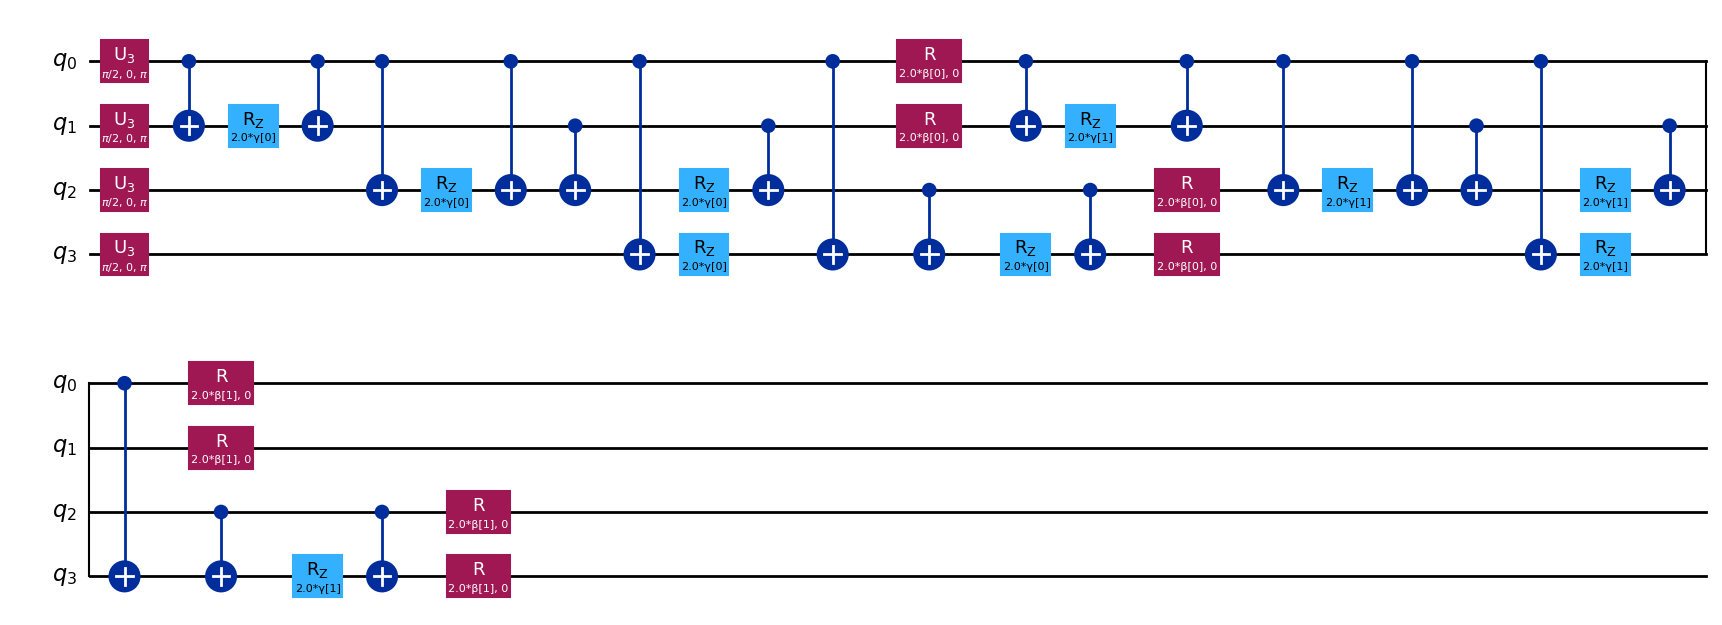

In [45]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

max_hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])


max_ansatz = QAOAAnsatz(max_hamiltonian, reps=2)
# Draw
max_ansatz.decompose(reps=3).draw("mpl")

In [46]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


In [47]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [ ]:
# We now set an initial set of random parameters:
import numpy as np

x0 = 2 * np.pi * np.random.rand(max_ansatz.num_parameters)
print(x0)

[3.46221579 5.10882197 0.03075299 5.04413676]


Any classical optimizer can be used to minimize the cost function. On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better. Here we use the COBYLA routine from SciPy via the minimize function.

Because we are iteratively executing many calls to Runtime, we make use of a Session in order to execute all calls within a single block. Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization. Therefore, we will need a Sampler primitive as well, and will instantiate it with the same Session

And run our minimization routine:

In [49]:
result = minimize(cost_func, x0, args=(max_ansatz, max_hamiltonian, estimator), method="COBYLA")
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8698124695764218
       x: [ 4.481e+00  4.901e+00  3.137e-01  5.475e+00]
    nfev: 204
   maxcv: 0.0


The solution vector of parameter angles ( x ), when plugged into the ansatz circuit, yields the graph partitioning that we were looking for.

In [50]:
eigenvalue = cost_func(result.x, max_ansatz, max_hamiltonian, estimator)
print(f"""Eigenvalue: {eigenvalue}""")
print(f"""Max-Cut Objective: {eigenvalue + offset}""")

Eigenvalue: -1.8698124695764218
Max-Cut Objective: -4.369812469576422


In [51]:
from qiskit.result import QuasiDistribution
from qiskit.primitives import StatevectorSampler
sampler = StatevectorSampler()

# Assign solution parameters to ansatz
qc = max_ansatz.assign_parameters(result.x)

# Add measurements to our circuit
qc.measure_all()

# Sample ansatz at optimal parameters
#samp_dist = sampler.run(qc).result().quasi_dists[0]

shots = 1024
job = sampler.run([qc], shots = shots)

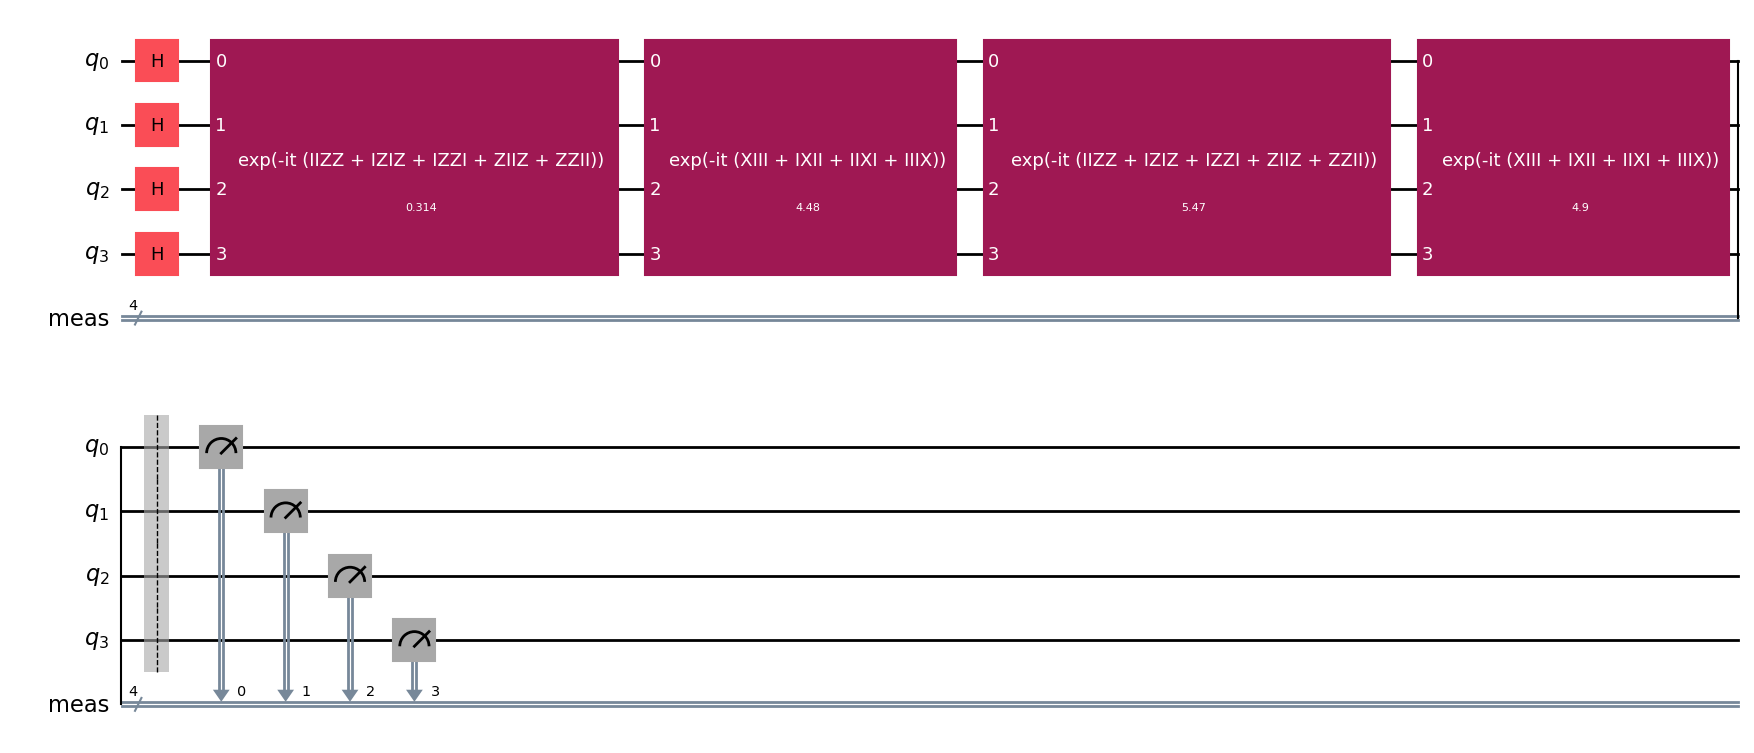

In [52]:
qc.decompose().draw('mpl')

In [53]:
data_pub = job.result()[0].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})
probabilities = quasi_dist

# Close the session since we are now done with it
session.close()

NameError: name 'session' is not defined

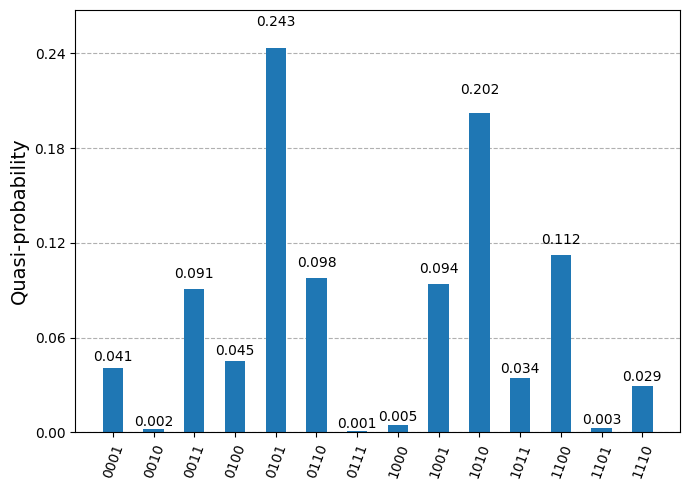

In [54]:
from qiskit.visualization import plot_distribution
plot_distribution(counts)

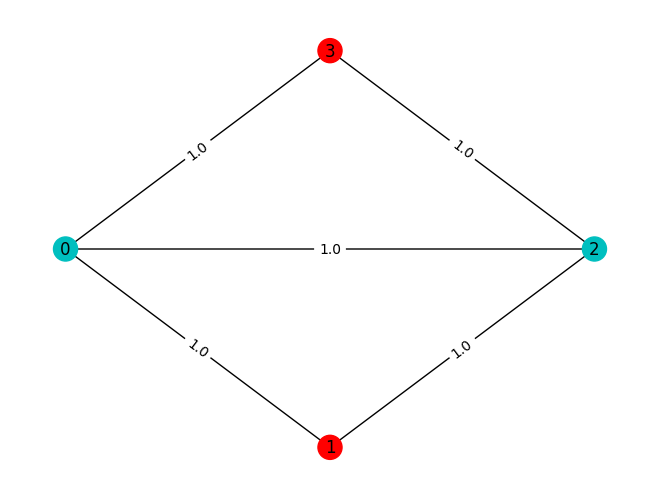

In [55]:
binary_string = max(counts.items(), key=lambda kv: kv[1])[0]
x = np.asarray([int(y) for y in reversed(list(binary_string))])

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color=colors)

## Summary

With this lesson, you have learned:

- How to write a custom variational algorithm
- How to apply a variational algorithm to find minimum eigenvalues
- How to utilize variational algorithms to solve application use cases